Saving SPS 1000.jpg to SPS 1000.jpg


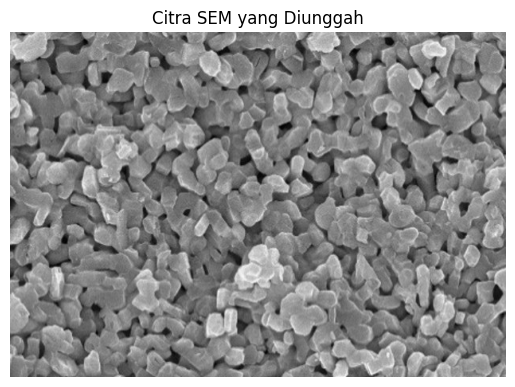

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# --- Upload Gambar ---
uploaded = files.upload()

# --- Baca Gambar Pertama yang Diunggah ---
for filename in uploaded.keys():
    image_path = filename
    break

# --- Load dan Prasaring Citra ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# --- Visualisasi Citra Asli ---
plt.imshow(image, cmap='gray')
plt.title("Citra SEM yang Diunggah")
plt.axis('off')
plt.show()


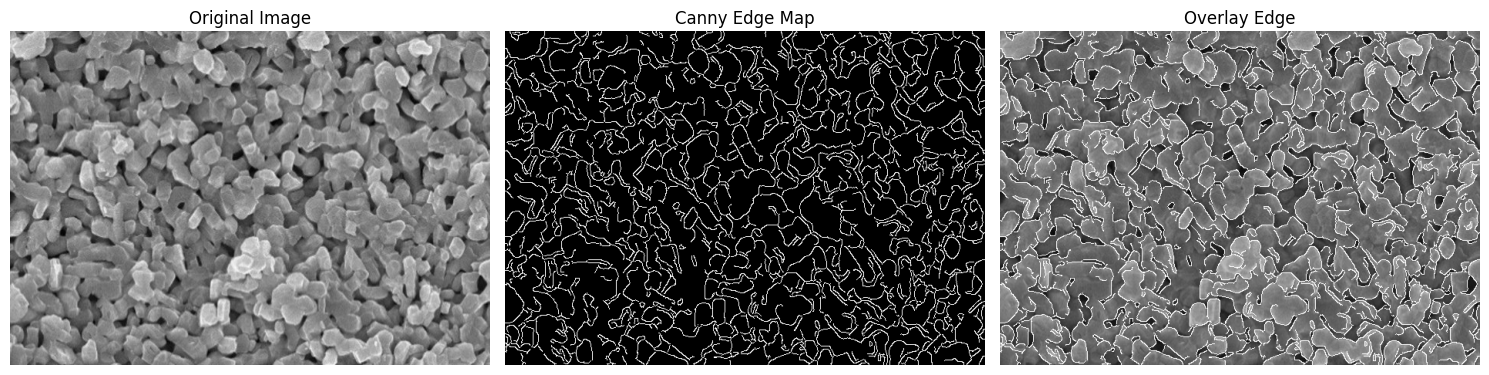


📊 Hasil Analisis Semua Augmentasi:
   Porosity (%)  Jumlah Pori    Mean Area      STD Area  Mean Aspect Ratio  \
0     11.158849    75.000000  1566.133333  10848.409120           2.079275   
1     11.189617    75.000000  1566.133333  10848.409120           2.079275   
2     11.175531    75.000000  1566.133333  10848.409120           2.079275   
3     11.152177    75.000000  1566.133333  10848.409120           2.079275   
4     11.189617    75.000000  1566.133333  10848.409120           2.079275   
5     11.152177    75.000000  1566.133333  10848.409120           2.079275   
6     11.638166    69.000000  1749.623188  12038.447086           2.145295   
7     10.724017    72.000000  1639.236111  11450.322705           2.089567   
8     11.242998    74.000000  1588.189189  10916.537527           2.131168   
9     11.180350    73.888889  1597.094277  11055.084671           2.093520   

   Mean Eccentricity Augmentasi ke-  
0           0.812381              0  
1           0.812381         

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import random

# --- Fungsi Augmentasi dengan kontrol ketat ---
def augment_image(image):
    augmented_images = []

    # Rotasi (aman)
    for angle in [90, 180, 270]:
        rot = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        augmented_images.append(rot)

    # Flip (aman)
    augmented_images.append(cv2.flip(image, 0))  # Flip vertikal
    augmented_images.append(cv2.flip(image, 1))  # Flip horizontal

    # Brightness Adjustment (dibatasi)
    brighter = cv2.convertScaleAbs(image, alpha=1.05, beta=10)  # dari 1.2 & 30 → lebih moderat
    darker = cv2.convertScaleAbs(image, alpha=0.95, beta=-10)
    augmented_images.extend([brighter, darker])

    # Gaussian Noise (dibatasi)
    def add_noise(img):
        noise = np.random.normal(0, 5, img.shape).astype(np.int16)  # dari 10 → 5
        noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy
    augmented_images.append(add_noise(image))

    return augmented_images

# --- Fungsi Analisis ---
def analyze_image(img, show_plot=False):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    total_pixels = edges.size
    edge_pixels = np.sum(edges > 0)
    edge_based_porosity = 100 * (edge_pixels / total_pixels)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    labels = measure.label(binary_inv, connectivity=2)
    props = measure.regionprops(labels)

    area_list, aspect_ratios, eccentricities = [], [], []
    for prop in props:
        if prop.area > 10:
            area_list.append(prop.area)
            aspect_ratios.append(prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0)
            eccentricities.append(prop.eccentricity)

    results = {
        "Porosity (%)": edge_based_porosity,
        "Jumlah Pori": len(area_list),
        "Mean Area": np.mean(area_list) if area_list else 0,
        "STD Area": np.std(area_list) if area_list else 0,
        "Mean Aspect Ratio": np.mean(aspect_ratios) if aspect_ratios else 0,
        "Mean Eccentricity": np.mean(eccentricities) if eccentricities else 0,
    }

    if show_plot:
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8,
                                  cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.8, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay Edge')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results

# --- Load dan Proses Gambar ---
image_path = 'SPS 1000.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

augmented_images = augment_image(image)
all_results = []

# Asli
original_res = analyze_image(image, show_plot=True)
original_res['Augmentasi ke-'] = 0
all_results.append(original_res)

# Augmentasi (akan disaring)
for idx, aug_img in enumerate(augmented_images):
    res = analyze_image(aug_img, show_plot=False)
    res['Augmentasi ke-'] = idx + 1
    all_results.append(res)

# Buat DataFrame
df = pd.DataFrame(all_results)

# Hitung rata-rata keseluruhan
avg_result = df.drop(columns=['Augmentasi ke-']).mean().to_frame(name='Rata-rata').T
avg_result['Augmentasi ke-'] = 'Rata-rata'
df_all = pd.concat([df, avg_result], ignore_index=True)

# --- Filter jika perlu ---
maks_porositas = 13.2
avg_porositas = avg_result["Porosity (%)"].values[0]

print("\n📊 Hasil Analisis Semua Augmentasi:")
print(df_all)

if avg_porositas > maks_porositas:
    print(f"\n⚠️ Rata-rata porositas {avg_porositas:.2f}% melebihi batas {maks_porositas}%. Coba kurangi augmentasi agresif.")
else:
    print(f"\n✅ Rata-rata porositas {avg_porositas:.2f}% berada dalam batas aman (≤ {maks_porositas}%).")

# Simpan jika perlu
# df_all.to_excel("hasil_analisis_augmented_dengan_overlay_terkontrol.xlsx", index=False)

Saving SPS 1100.jpg to SPS 1100.jpg


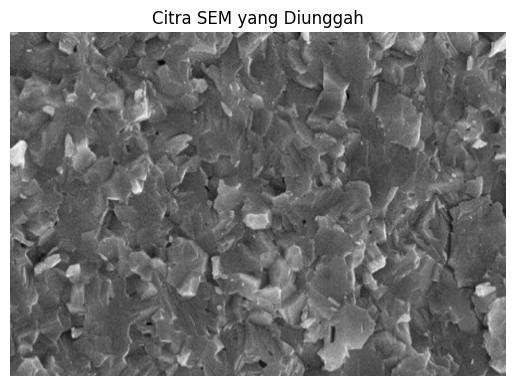

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# --- Upload Gambar ---
uploaded = files.upload()

# --- Baca Gambar Pertama yang Diunggah ---
for filename in uploaded.keys():
    image_path = filename
    break

# --- Load dan Prasaring Citra ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# --- Visualisasi Citra Asli ---
plt.imshow(image, cmap='gray')
plt.title("Citra SEM yang Diunggah")
plt.axis('off')
plt.show()

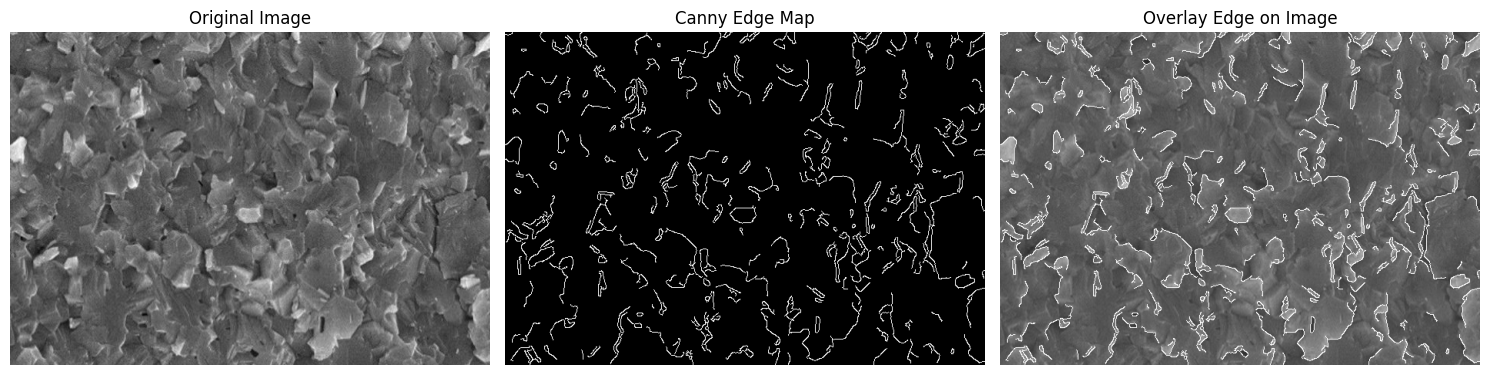


📊 Hasil Analisis Semua Augmentasi:
    Porosity (%)  Jumlah Pori    Mean Area      STD Area  Mean Aspect Ratio  \
0       4.638923         31.0  6473.354839  35240.785379           2.107820   
1       4.613016         31.0  6473.354839  35240.785379           2.107820   
2       4.630781         31.0  6473.354839  35240.785379           2.107820   
3       4.659279         31.0  6473.354839  35240.785379           2.107820   
4       4.630781         31.0  6473.354839  35240.785379           2.107820   
5       4.613016         31.0  6473.354839  35240.785379           2.107820   
6       4.659279         31.0  6473.354839  35240.785379           2.107820   
7       6.560150         32.0  6190.593750  34257.104499           2.104741   
8       2.817256         33.0  6033.060606  33928.224646           2.113174   
9      36.028084        364.0   351.296703   5144.529711           2.021776   
10      7.785057         64.6  5788.843493  32001.535651           2.099443   

    Mean Eccent

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import random

# --- Fungsi Augmentasi ---
def augment_image(image):
    augmented_images = []

    # Rotasi
    for angle in [0, 90, 180, 270]:
        rot = cv2.rotate(image, {
            0: cv2.ROTATE_90_CLOCKWISE,
            90: cv2.ROTATE_180,
            180: cv2.ROTATE_90_COUNTERCLOCKWISE,
            270: cv2.ROTATE_180
        }[angle])
        augmented_images.append(rot)

    # Flip
    augmented_images.append(cv2.flip(image, 0))  # Flip vertical
    augmented_images.append(cv2.flip(image, 1))  # Flip horizontal

    # Brightness Adjustment
    brighter = cv2.convertScaleAbs(image, alpha=1.2, beta=30)
    darker = cv2.convertScaleAbs(image, alpha=0.8, beta=-30)
    augmented_images.extend([brighter, darker])

    # Gaussian Noise
    def add_noise(img):
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        return cv2.add(img, noise)
    augmented_images.append(add_noise(image))

    return augmented_images

# --- Analisis dan Visualisasi ---
def analyze_image(img, show_plot=False):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    total_pixels = edges.size
    edge_pixels = np.sum(edges > 0)
    edge_based_porosity = 100 * (edge_pixels / total_pixels)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    labels = measure.label(binary_inv, connectivity=2)
    props = measure.regionprops(labels)

    area_list = []
    aspect_ratios = []
    eccentricities = []
    for prop in props:
        if prop.area > 10:
            area_list.append(prop.area)
            aspect_ratios.append(prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0)
            eccentricities.append(prop.eccentricity)

    results = {
        "Porosity (%)": edge_based_porosity,
        "Jumlah Pori": len(area_list),
        "Mean Area": np.mean(area_list) if area_list else 0,
        "STD Area": np.std(area_list) if area_list else 0,
        "Mean Aspect Ratio": np.mean(aspect_ratios) if aspect_ratios else 0,
        "Mean Eccentricity": np.mean(eccentricities) if eccentricities else 0,
    }

    if show_plot:
        # Overlay edge ke original
        edge_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8, edge_color, 0.8, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay Edge on Image')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results

# --- Load Gambar ---
image_path = 'SPS 1100.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

# --- Augmentasi dan Analisis ---
augmented_images = augment_image(image)
all_results = []

# Analisis gambar asli
original_res = analyze_image(image, show_plot=True)
original_res['Augmentasi ke-'] = 0
all_results.append(original_res)

# Analisis hasil augmentasi
for idx, aug_img in enumerate(augmented_images):
    res = analyze_image(aug_img, show_plot=False)  # Ubah ke True jika ingin tampil semua
    res['Augmentasi ke-'] = idx + 1
    all_results.append(res)

# --- DataFrame hasil ---
df = pd.DataFrame(all_results)

# Hitung rata-rata dari semua hasil
avg_result = df.drop(columns=['Augmentasi ke-']).mean().to_frame(name='Rata-rata').T
avg_result['Augmentasi ke-'] = 'Rata-rata'

# Gabungkan semua ke bawah
df_all = pd.concat([df, avg_result], ignore_index=True)

# Tampilkan hasil
print("\n📊 Hasil Analisis Semua Augmentasi:")
print(df_all)

# Simpan jika perlu
# df_all.to_excel("hasil_analisis_augmented_dengan_overlay.xlsx", index=False)

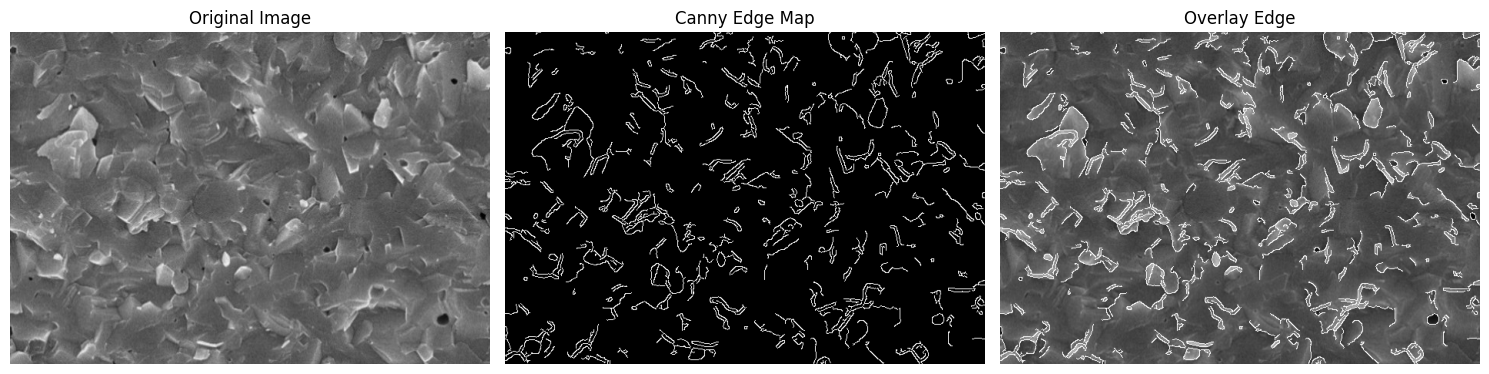


📊 Hasil Analisis Semua Augmentasi:
   Porosity (%)  Jumlah Pori     Mean Area      STD Area  Mean Aspect Ratio  \
0      5.635313         17.0  12293.764706  48963.579106           2.145577   
1      5.654603         17.0  12293.764706  48963.579106           2.145577   
2      5.705425         17.0  12293.764706  48963.579106           2.145577   
3      5.661280         17.0  12293.764706  48963.579106           2.145577   
4      5.654603         17.0  12293.764706  48963.579106           2.145577   
5      5.661280         17.0  12293.764706  48963.579106           2.145577   
6      5.993664         16.0  13080.687500  50445.450932           2.196259   
7      5.232817         16.0  13045.937500  50312.671072           2.145490   
8      5.661651         19.0  10990.736842  46443.562670           2.215303   
9      5.651182         17.0  12319.994453  48998.128812           2.158946   

   Mean Eccentricity Augmentasi ke-  
0           0.801675              0  
1           0.8016

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import random

# --- Fungsi Augmentasi dengan kontrol ketat ---
def augment_image(image):
    augmented_images = []

    # Rotasi (aman)
    for angle in [90, 180, 270]:
        rot = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        augmented_images.append(rot)

    # Flip (aman)
    augmented_images.append(cv2.flip(image, 0))  # Flip vertikal
    augmented_images.append(cv2.flip(image, 1))  # Flip horizontal

    # Brightness Adjustment (dibatasi)
    brighter = cv2.convertScaleAbs(image, alpha=1.05, beta=10)  # dari 1.2 & 30 → lebih moderat
    darker = cv2.convertScaleAbs(image, alpha=0.95, beta=-10)
    augmented_images.extend([brighter, darker])

    # Gaussian Noise (dibatasi)
    def add_noise(img):
        noise = np.random.normal(0, 5, img.shape).astype(np.int16)  # dari 10 → 5
        noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy
    augmented_images.append(add_noise(image))

    return augmented_images

# --- Fungsi Analisis ---
def analyze_image(img, show_plot=False):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    total_pixels = edges.size
    edge_pixels = np.sum(edges > 0)
    edge_based_porosity = 100 * (edge_pixels / total_pixels)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    labels = measure.label(binary_inv, connectivity=2)
    props = measure.regionprops(labels)

    area_list, aspect_ratios, eccentricities = [], [], []
    for prop in props:
        if prop.area > 10:
            area_list.append(prop.area)
            aspect_ratios.append(prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0)
            eccentricities.append(prop.eccentricity)

    results = {
        "Porosity (%)": edge_based_porosity,
        "Jumlah Pori": len(area_list),
        "Mean Area": np.mean(area_list) if area_list else 0,
        "STD Area": np.std(area_list) if area_list else 0,
        "Mean Aspect Ratio": np.mean(aspect_ratios) if aspect_ratios else 0,
        "Mean Eccentricity": np.mean(eccentricities) if eccentricities else 0,
    }

    if show_plot:
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8,
                                  cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.8, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay Edge')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results

# --- Load dan Proses Gambar ---
image_path = 'SPS 1100 15.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

augmented_images = augment_image(image)
all_results = []

# Asli
original_res = analyze_image(image, show_plot=True)
original_res['Augmentasi ke-'] = 0
all_results.append(original_res)

# Augmentasi (akan disaring)
for idx, aug_img in enumerate(augmented_images):
    res = analyze_image(aug_img, show_plot=False)
    res['Augmentasi ke-'] = idx + 1
    all_results.append(res)

# Buat DataFrame
df = pd.DataFrame(all_results)

# Hitung rata-rata keseluruhan
avg_result = df.drop(columns=['Augmentasi ke-']).mean().to_frame(name='Rata-rata').T
avg_result['Augmentasi ke-'] = 'Rata-rata'
df_all = pd.concat([df, avg_result], ignore_index=True)

# --- Filter jika perlu ---
maks_porositas = 9.10
avg_porositas = avg_result["Porosity (%)"].values[0]

print("\n📊 Hasil Analisis Semua Augmentasi:")
print(df_all)

if avg_porositas > maks_porositas:
    print(f"\n⚠️ Rata-rata porositas {avg_porositas:.2f}% melebihi batas {maks_porositas}%. Coba kurangi augmentasi agresif.")
else:
    print(f"\n✅ Rata-rata porositas {avg_porositas:.2f}% berada dalam batas aman (≤ {maks_porositas}%).")

# Simpan jika perlu
# df_all.to_excel("hasil_analisis_augmented_dengan_overlay_terkontrol.xlsx", index=False)


Saving PS 1100.jpg to PS 1100.jpg


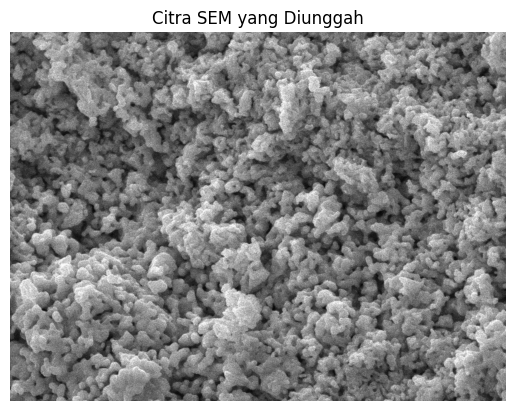

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# --- Upload Gambar ---
uploaded = files.upload()

# --- Baca Gambar Pertama yang Diunggah ---
for filename in uploaded.keys():
    image_path = filename
    break

# --- Load dan Prasaring Citra ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# --- Visualisasi Citra Asli ---
plt.imshow(image, cmap='gray')
plt.title("Citra SEM yang Diunggah")
plt.axis('off')
plt.show()

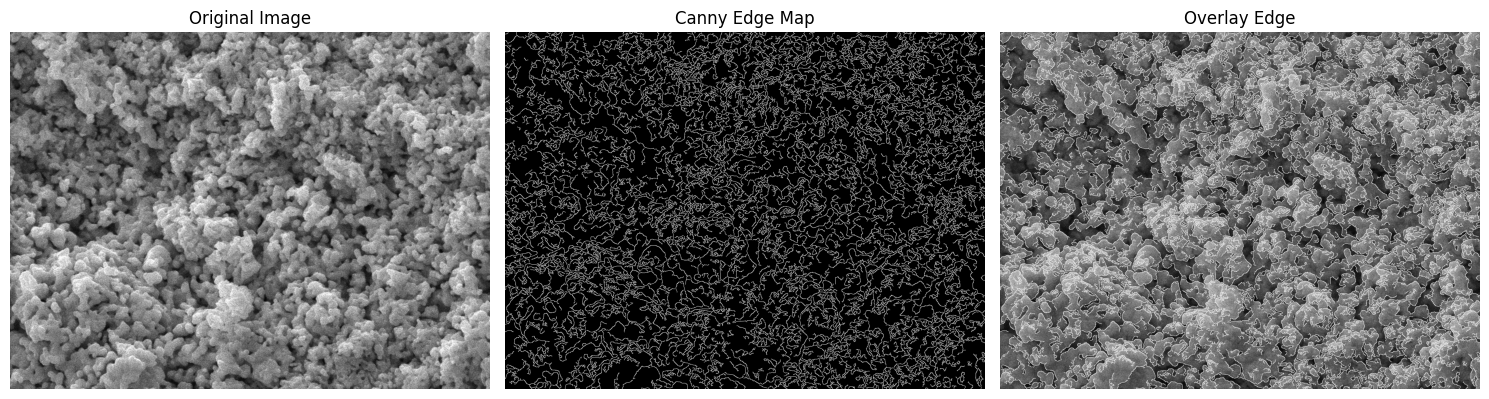


📊 Hasil Analisis Semua Augmentasi:
   Porosity (%)  Jumlah Pori    Mean Area      STD Area  Mean Aspect Ratio  \
0     12.467762   343.000000  1758.918367  15834.389716           2.036175   
1     12.454032   343.000000  1758.918367  15834.389716           2.036175   
2     12.410211   343.000000  1758.918367  15834.389716           2.036175   
3     12.427476   343.000000  1758.918367  15834.389716           2.036175   
4     12.454032   343.000000  1758.918367  15834.389716           2.036175   
5     12.427476   343.000000  1758.918367  15834.389716           2.036175   
6     13.101143   345.000000  1745.339130  15694.452699           2.036404   
7     11.383104   339.000000  1784.106195  16025.448395           2.027868   
8     12.640906   335.000000  1800.155224  16759.085885           2.010058   
9     12.418460   341.888889  1764.790084  15942.813919           2.032376   

   Mean Eccentricity Augmentasi ke-  
0           0.811349              0  
1           0.811349         

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import random

# --- Fungsi Augmentasi dengan kontrol ketat ---
def augment_image(image):
    augmented_images = []

    # Rotasi (aman)
    for angle in [90, 180, 270]:
        rot = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        augmented_images.append(rot)

    # Flip (aman)
    augmented_images.append(cv2.flip(image, 0))  # Flip vertikal
    augmented_images.append(cv2.flip(image, 1))  # Flip horizontal

    # Brightness Adjustment (dibatasi)
    brighter = cv2.convertScaleAbs(image, alpha=1.05, beta=10)  # dari 1.2 & 30 → lebih moderat
    darker = cv2.convertScaleAbs(image, alpha=0.95, beta=-10)
    augmented_images.extend([brighter, darker])

    # Gaussian Noise (dibatasi)
    def add_noise(img):
        noise = np.random.normal(0, 5, img.shape).astype(np.int16)  # dari 10 → 5
        noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy
    augmented_images.append(add_noise(image))

    return augmented_images

# --- Fungsi Analisis ---
def analyze_image(img, show_plot=False):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    total_pixels = edges.size
    edge_pixels = np.sum(edges > 0)
    edge_based_porosity = 100 * (edge_pixels / total_pixels)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    labels = measure.label(binary_inv, connectivity=2)
    props = measure.regionprops(labels)

    area_list, aspect_ratios, eccentricities = [], [], []
    for prop in props:
        if prop.area > 10:
            area_list.append(prop.area)
            aspect_ratios.append(prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0)
            eccentricities.append(prop.eccentricity)

    results = {
        "Porosity (%)": edge_based_porosity,
        "Jumlah Pori": len(area_list),
        "Mean Area": np.mean(area_list) if area_list else 0,
        "STD Area": np.std(area_list) if area_list else 0,
        "Mean Aspect Ratio": np.mean(aspect_ratios) if aspect_ratios else 0,
        "Mean Eccentricity": np.mean(eccentricities) if eccentricities else 0,
    }

    if show_plot:
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8,
                                  cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.8, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay Edge')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results

# --- Load dan Proses Gambar ---
image_path = 'PS 1100.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

augmented_images = augment_image(image)
all_results = []

# Asli
original_res = analyze_image(image, show_plot=True)
original_res['Augmentasi ke-'] = 0
all_results.append(original_res)

# Augmentasi (akan disaring)
for idx, aug_img in enumerate(augmented_images):
    res = analyze_image(aug_img, show_plot=False)
    res['Augmentasi ke-'] = idx + 1
    all_results.append(res)

# Buat DataFrame
df = pd.DataFrame(all_results)

# Hitung rata-rata keseluruhan
avg_result = df.drop(columns=['Augmentasi ke-']).mean().to_frame(name='Rata-rata').T
avg_result['Augmentasi ke-'] = 'Rata-rata'
df_all = pd.concat([df, avg_result], ignore_index=True)

# --- Filter jika perlu ---
maks_porositas = 21.39
avg_porositas = avg_result["Porosity (%)"].values[0]

print("\n📊 Hasil Analisis Semua Augmentasi:")
print(df_all)

if avg_porositas > maks_porositas:
    print(f"\n⚠️ Rata-rata porositas {avg_porositas:.2f}% melebihi batas {maks_porositas}%. Coba kurangi augmentasi agresif.")
else:
    print(f"\n✅ Rata-rata porositas {avg_porositas:.2f}% berada dalam batas aman (≤ {maks_porositas}%).")

# Simpan jika perlu
# df_all.to_excel("hasil_analisis_augmented_dengan_overlay_terkontrol.xlsx", index=False)

Saving PS 1200.jpg to PS 1200.jpg


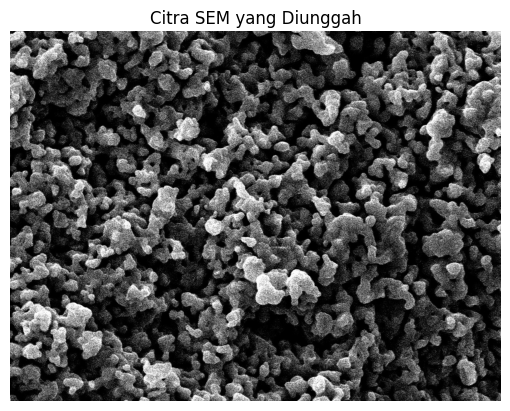

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# --- Upload Gambar ---
uploaded = files.upload()

# --- Baca Gambar Pertama yang Diunggah ---
for filename in uploaded.keys():
    image_path = filename
    break

# --- Load dan Prasaring Citra ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# --- Visualisasi Citra Asli ---
plt.imshow(image, cmap='gray')
plt.title("Citra SEM yang Diunggah")
plt.axis('off')
plt.show()

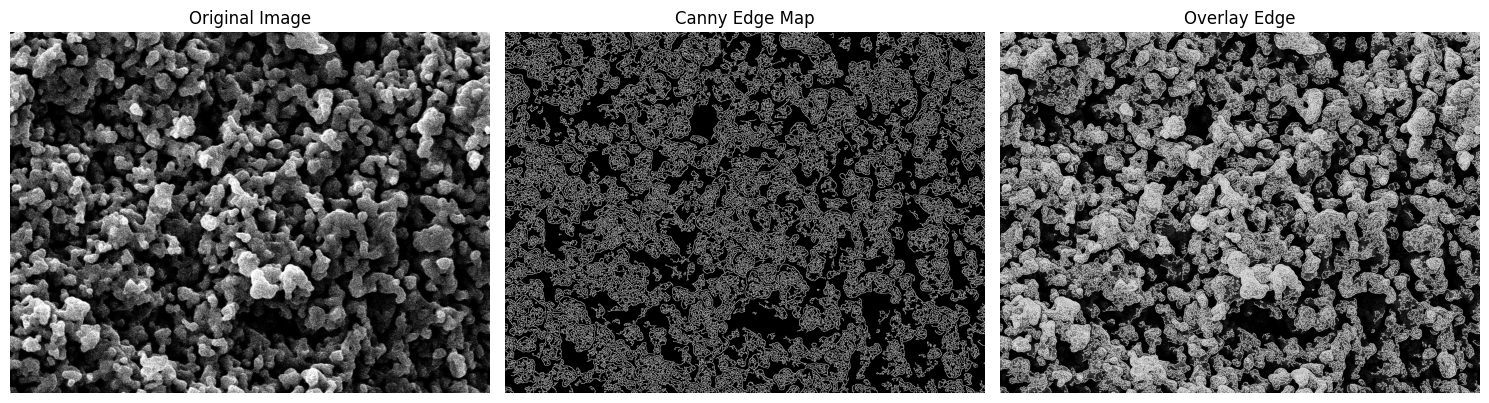


📊 Hasil Analisis Semua Augmentasi:
   Porosity (%)  Jumlah Pori    Mean Area      STD Area  Mean Aspect Ratio  \
0     20.536903   206.000000  3738.844660  52091.780802           2.074671   
1     20.536327   206.000000  3738.844660  52091.780802           2.074671   
2     20.520953   206.000000  3738.844660  52091.780802           2.074671   
3     20.519638   206.000000  3738.844660  52091.780802           2.074671   
4     20.536327   206.000000  3738.844660  52091.780802           2.074671   
5     20.519638   206.000000  3738.844660  52091.780802           2.074671   
6     21.036431   224.000000  3407.750000  49288.766557           2.035601   
7     18.799487   176.000000  4633.693182  60705.938759           2.024003   
8     20.588862   223.000000  3453.551570  50080.660660           2.037910   
9     20.399396   206.555556  3769.784746  52514.005643           2.060616   

   Mean Eccentricity Augmentasi ke-  
0           0.806571              0  
1           0.806571         

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import random

# --- Fungsi Augmentasi dengan kontrol ketat ---
def augment_image(image):
    augmented_images = []

    # Rotasi (aman)
    for angle in [90, 180, 270]:
        rot = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        augmented_images.append(rot)

    # Flip (aman)
    augmented_images.append(cv2.flip(image, 0))  # Flip vertikal
    augmented_images.append(cv2.flip(image, 1))  # Flip horizontal

    # Brightness Adjustment (dibatasi)
    brighter = cv2.convertScaleAbs(image, alpha=1.05, beta=10)  # dari 1.2 & 30 → lebih moderat
    darker = cv2.convertScaleAbs(image, alpha=0.95, beta=-10)
    augmented_images.extend([brighter, darker])

    # Gaussian Noise (dibatasi)
    def add_noise(img):
        noise = np.random.normal(0, 5, img.shape).astype(np.int16)  # dari 10 → 5
        noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy
    augmented_images.append(add_noise(image))

    return augmented_images

# --- Fungsi Analisis ---
def analyze_image(img, show_plot=False):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    total_pixels = edges.size
    edge_pixels = np.sum(edges > 0)
    edge_based_porosity = 100 * (edge_pixels / total_pixels)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    labels = measure.label(binary_inv, connectivity=2)
    props = measure.regionprops(labels)

    area_list, aspect_ratios, eccentricities = [], [], []
    for prop in props:
        if prop.area > 10:
            area_list.append(prop.area)
            aspect_ratios.append(prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0)
            eccentricities.append(prop.eccentricity)

    results = {
        "Porosity (%)": edge_based_porosity,
        "Jumlah Pori": len(area_list),
        "Mean Area": np.mean(area_list) if area_list else 0,
        "STD Area": np.std(area_list) if area_list else 0,
        "Mean Aspect Ratio": np.mean(aspect_ratios) if aspect_ratios else 0,
        "Mean Eccentricity": np.mean(eccentricities) if eccentricities else 0,
    }

    if show_plot:
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8,
                                  cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.8, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay Edge')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results

# --- Load dan Proses Gambar ---
image_path = 'PS 1200.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

augmented_images = augment_image(image)
all_results = []

# Asli
original_res = analyze_image(image, show_plot=True)
original_res['Augmentasi ke-'] = 0
all_results.append(original_res)

# Augmentasi (akan disaring)
for idx, aug_img in enumerate(augmented_images):
    res = analyze_image(aug_img, show_plot=False)
    res['Augmentasi ke-'] = idx + 1
    all_results.append(res)

# Buat DataFrame
df = pd.DataFrame(all_results)

# Hitung rata-rata keseluruhan
avg_result = df.drop(columns=['Augmentasi ke-']).mean().to_frame(name='Rata-rata').T
avg_result['Augmentasi ke-'] = 'Rata-rata'
df_all = pd.concat([df, avg_result], ignore_index=True)

# --- Filter jika perlu ---
maks_porositas = 21.39
avg_porositas = avg_result["Porosity (%)"].values[0]

print("\n📊 Hasil Analisis Semua Augmentasi:")
print(df_all)

if avg_porositas > maks_porositas:
    print(f"\n⚠️ Rata-rata porositas {avg_porositas:.2f}% melebihi batas {maks_porositas}%. Coba kurangi augmentasi agresif.")
else:
    print(f"\n✅ Rata-rata porositas {avg_porositas:.2f}% berada dalam batas aman (≤ {maks_porositas}%).")

# Simpan jika perlu
# df_all.to_excel("hasil_analisis_augmented_dengan_overlay_terkontrol.xlsx", index=False)